In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC

from preprocessing import preprocesamiento_basico, normalizar_datos
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV, mapear_target_binario

# Support Vector Machines

### Obtención de los datos y preprocesamiento

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


Aplicamos metodo de feature engineering general

In [3]:
dataframes_procesados = preprocesamiento_basico([X_train, X_test])
X_train = dataframes_procesados[0]
X_test = dataframes_procesados[1]

Además es buena práctica realizar una normalización previa de las escalas de los datos, por lo que recurriremos al siguiente preprocesamiento adicional:

In [4]:
dataframes_normalizados = normalizar_datos([X_train, X_test])
X_train = dataframes_normalizados[0]
X_test = dataframes_normalizados[1]

### Búsqueda de Hiperparámetros

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. En el caso de SVM, estos serán 'C' (dureza ante outliers), 'kernel' (el kernel a utilizar para evitar problemas linealmente inseparables), 'degree' (grado del kernel polinomial, ignorado por los otros kernels) y  'max_iter' (el número máximo de iteraciones como criterio de paro).

In [6]:
params = {'C': [0.1, 1, 10], 'kernel': ['poly', 'rbf', 'sigmoid'], 'degree':[2,3,4], 'max_iter': [10000]}
hiperparametros = encontrar_hiperparametros_RGSCV(SVC(), params=params, x_np=X_train, y_np=y_train.to_numpy().ravel())

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [7]:
c_elegido = hiperparametros['C']
max_iter_elegida = hiperparametros['max_iter']
grado_elegido = hiperparametros['degree']
kernel_elegido = hiperparametros['kernel']
print(f'Mejor C: {c_elegido}')
print(f'Mejor iteración máxima: {max_iter_elegida}')
print(f'Mejor kernel: {kernel_elegido}')
print(f'Mejor grado para kernel polinomial: {grado_elegido}')

Mejor C: 0.1
Mejor iteración máxima: 10000
Mejor kernel: rbf
Mejor grado para kernel polinomial: 2


### Entrenando el Modelo con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [8]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    svm_clasificacion = SVC(max_iter=20000, C=c_elegido, kernel=kernel_elegido, degree=grado_elegido)
    svm_clasificacion.fit(X_train[train_index], y_train.iloc[train_index])
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], svm_clasificacion.predict(X_train[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.96      0.90     15891
   Llueven hamburguesas al dia siguiente       0.77      0.42      0.54      4581

                                accuracy                           0.84     20472
                               macro avg       0.81      0.69      0.72     20472
                            weighted avg       0.83      0.84      0.82     20472



C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.93      0.90     15891
   Llueven hamburguesas al dia siguiente       0.68      0.50      0.58      4580

                                accuracy                           0.84     20471
                               macro avg       0.77      0.72      0.74     20471
                            weighted avg       0.82      0.84      0.83     20471



C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 2
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.95      0.90     15891
   Llueven hamburguesas al dia siguiente       0.74      0.47      0.57      4580

                                accuracy                           0.84     20471
                               macro avg       0.80      0.71      0.74     20471
                            weighted avg       0.83      0.84      0.83     20471



C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 3
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.98      0.91     15891
   Llueven hamburguesas al dia siguiente       0.83      0.41      0.55      4580

                                accuracy                           0.85     20471
                               macro avg       0.84      0.69      0.73     20471
                            weighted avg       0.85      0.85      0.83     20471



C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Reporte para el FOLD 4
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.85      0.97      0.91     15890
   Llueven hamburguesas al dia siguiente       0.80      0.42      0.55      4581

                                accuracy                           0.85     20471
                               macro avg       0.83      0.70      0.73     20471
                            weighted avg       0.84      0.85      0.83     20471



### Predicción del modelo sobre holdout

Una vez entrenado y validado el modelo con CrossValidation, viendo que las métricas resultantes fueron razonables y no dan indicio de overfit o mala división del dataset, pasaremos a probar el modelo en la partición Holdout. Para esto usaremos los mejores hiperparámetros hallados previamente en Training.

In [9]:
svm_holdout = SVC(max_iter=50000, C=c_elegido, kernel=kernel_elegido, degree=grado_elegido, probability=True)
svm_holdout.fit(X_train, y_train.to_numpy().ravel())

SVC(C=0.1, degree=2, max_iter=50000, probability=True)

In [10]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = svm_holdout.predict(X_test)
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = svm_holdout.predict_proba(X_test)[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.86      0.96      0.91      8828
          si       0.78      0.46      0.58      2545

    accuracy                           0.85     11373
   macro avg       0.82      0.71      0.74     11373
weighted avg       0.84      0.85      0.83     11373



### Curva AUC ROC


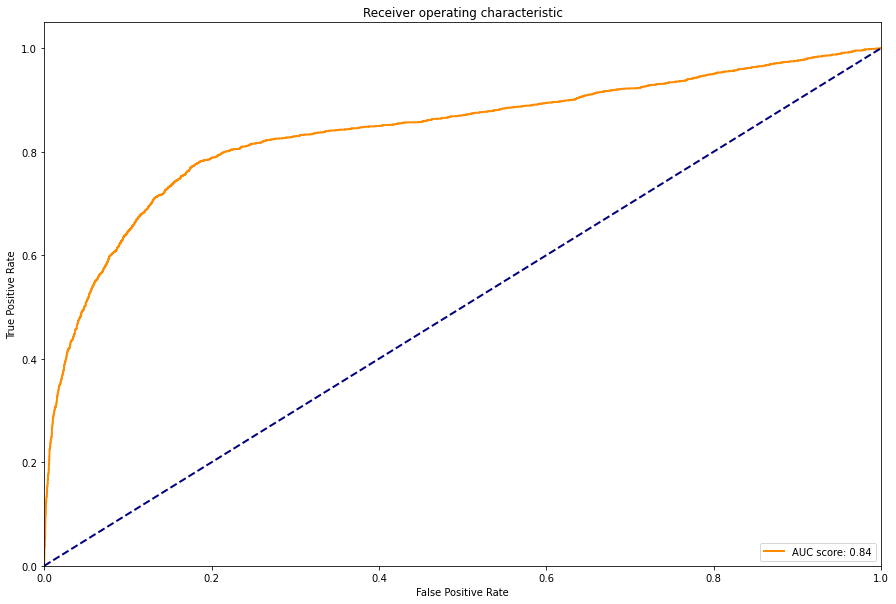

AUC-ROC para este modelo es: 0.8393908736534852


In [11]:
graficar_auc_roc(y_test_binario, y_pred_proba)

### Matriz de confusion

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


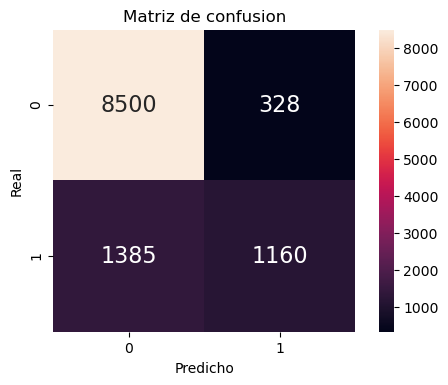

In [12]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el árbol sin expandir el dataset sobre el dataset de predicciones nuevo, y la escribimos al archivo 'SVM.csv'

In [14]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final = preprocesamiento_basico([df_prediccion_final])[0]
df_preddiccion_final = normalizar_datos([df_prediccion_final])[0]
predicciones = svm_holdout.predict(df_prediccion_final.to_numpy())

exportar_prediccion_final(ids, predicciones, 'SVM')